# The parametric pump for steady-state entanglement


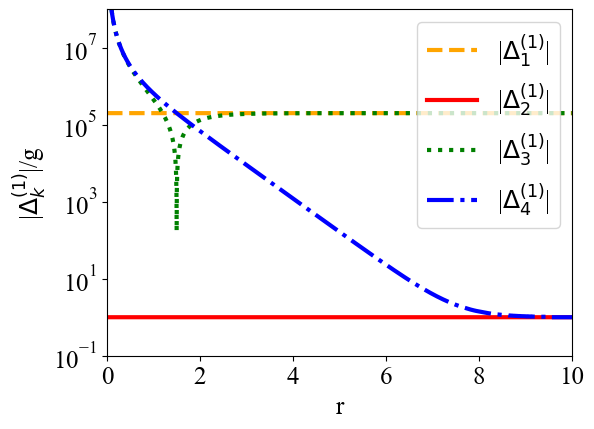

In [65]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time

# Start timing
start_time = time.time()


# parameters
g = 1  # Coupling strength, unit 1
kappa = 50 * g # make sure kappa>>g\cosh(r)
omega_0 = g * 10**5
omega_a = g * 10**6
delta = 1
M = 10000
dr = np.linspace(0.001, 10, M)
fr = (1 - np.tanh(2*dr)**2)**0.5
omega_p = 2 * (omega_0 -  omega_a * fr) / (1 - fr)
omega_b = (omega_a - omega_p/2) * fr
Delta_1 = omega_p / 2 + omega_b + omega_0
Delta_2 = omega_p / 2 + omega_b - omega_0
Delta_3 = omega_p / 2 - omega_b + omega_0
Delta_4 = omega_p / 2 - omega_b - omega_0


Delta_11 = Delta_1 + delta
Delta_21 = Delta_2 - delta
Delta_31 = Delta_3 + delta
Delta_41 = Delta_4 - delta


# save the data
np.savetxt('sr_parameter.txt', np.column_stack((dr, abs(Delta_1), abs(Delta_2), abs(Delta_3), abs(Delta_4))), delimiter=' ')

# figure
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(dr, abs(Delta_11), label='|$\Delta_1^{(1)}$|', linewidth=3, linestyle='--', color='orange')  
ax.plot(dr, abs(Delta_21), label='|$\Delta$$_2^{(1)}$|', linewidth=3, linestyle='-', color='r')  
ax.plot(dr, abs(Delta_31), label='|$\Delta$$_3^{(1)}$|', linewidth=3, linestyle=':', color='g')  
ax.plot(dr, abs(Delta_41), label='|$\Delta$$_4^{(1)}$|', linewidth=3, linestyle='-.', color='b')  
plt.yscale('log')
# title, label and scale
ax.axis([0, 10, 10**-1, 10**8])

ax.set_xlabel('r')
ax.set_ylabel('|$\Delta$$_k^{(1)}$|/g')
ax.tick_params(axis='both', which='major')

# legend
plt.legend(loc='upper right')
plt.show()


In [63]:
# run this unit first. this unit includes all functions that we used.

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time

def H1_coeff(t, args):        
    return np.exp(1j * Delta_1 * t)
def H1m_coeff(t, args):        
    return np.exp(-1j * Delta_1 * t)
def H2_coeff(t, args):        
    return np.exp(1j * Delta_2 * t)
def H2m_coeff(t, args):        
    return np.exp(-1j * Delta_2 * t)
def H3_coeff(t, args):        
    return np.exp(1j * Delta_3 * t)
def H3m_coeff(t, args):        
    return np.exp(-1j * Delta_3 * t)
def H4_coeff(t, args):        
    return np.exp(1j * Delta_4 * t)
def H4m_coeff(t, args):        
    return np.exp(-1j * Delta_4 * t)


# Operators for two-level emitters and cavity
N = 2  # Two-level emitter
Na = 6  # Cavity photon number truncation
sigma_1 = tensor(sigmam(), qeye(N), qeye(Na))  # Lowering operator for emitter 1
sigma_2 = tensor(qeye(N), sigmam(), qeye(Na))  # Lowering operator for emitter 2
a = tensor(qeye(N), qeye(N), destroy(Na))  # Photon annihilation operator
S = sigma_1 + sigma_2  # Collective spin operator
N1 = sigma_1.dag() * sigma_1
N2 = sigma_2.dag() * sigma_2

# Initial and target states
psi_0 = tensor(basis(N, 0), basis(N, 1), basis(Na, 0))  # Initial state |100>
phi = (tensor(basis(N, 0), basis(N, 1)) - tensor(basis(N, 1), basis(N, 0))) / math.sqrt(2)  # Target state

# operators and states after tracing the cavity mode
sigma_1_eff = tensor(sigmam(), qeye(N)) # lowering operator for emitter 1
sigma_2_eff = tensor(qeye(N), sigmam()) # lowering operator for emitter 2
N1_eff = sigma_1_eff.dag() * sigma_1_eff
N2_eff = sigma_2_eff.dag() * sigma_2_eff
S_eff = sigma_1_eff + sigma_2_eff # collective operator
psi_0_eff = tensor(basis(N, 0), basis(N, 1))


def sr_dynamics_full():
    H0 = delta * (N1 - N2) + Omega * (S + S.dag())
    H_full = [H0, 
             [gc*a.dag()*S.dag(), H1_coeff],   [gc*a*S, H1m_coeff], 
             [gc*a*S.dag(), H2m_coeff], [gc*a.dag()*S, H2_coeff],
             [-gs*a*S.dag(), H3_coeff],  [-gs*a.dag()*S, H3m_coeff], 
             [-gs*a.dag()*S.dag(), H4m_coeff], [-gs*a*S, H4_coeff]]
    colps_full = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_full = mesolve(H_full, psi_0, times, colps_full, [])
    N_aa = [expect(a.dag() * a, state) for state in data_full.states]
    F_full = [fidelity(phi, state.ptrace((0, 1))) for state in data_full.states]
    return F_full, N_aa

def sr_dynamics_RWA():
    H0 = delta * (N1 - N2) + Omega * (S + S.dag())
    H_RWA = [H0, 
            [gc*a*S.dag(), H2m_coeff], [gc*a.dag()*S, H2_coeff], 
            [-gs*a.dag()*S.dag(), H4m_coeff], [-gs*a*S, H4_coeff]]
    colps_RWA = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_RWA = mesolve(H_RWA, psi_0, times, colps_RWA, [])
    F_RWA = [fidelity(phi, state.ptrace((0, 1))) for state in data_RWA.states]
    return F_RWA

def sr_dynamics_eff():
    H_eff = delta * (N1_eff - N2_eff) + Omega * (S_eff + S_eff.dag()) + J_4 * S_eff * S_eff.dag()
    colps_eff =[math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma_2) * S_eff, math.sqrt(Gamma_4) * S_eff.dag()]
    data_eff = mesolve(H_eff, psi_0_eff, times, colps_eff, [])
    F_eff = [fidelity(phi, state) for state in data_eff.states]
    return F_eff

def sr_steadystate_eff():
    H_eff = delta * (N1_eff - N2_eff) + Omega * (S_eff + S_eff.dag()) + J_4 * S_eff * S_eff.dag()
    colps_eff =[math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma_2) * S_eff, math.sqrt(Gamma_4) * S_eff.dag()]
    rho_ss_eff = steadystate(H_eff, colps_eff)
    F_ss_eff = fidelity(phi, rho_ss_eff)
    return F_ss_eff

def sr_steadystate_H2():
    H_2 = delta * (N1 - N2) + Omega * (S + S.dag()) + gc * (a * S.dag() + a.dag() * S)
    colps_H2 =[math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    rho_ss_H2 = steadystate(H_2, colps_H2)
    F_ss_H2 = fidelity(phi, rho_ss_H2.ptrace((0, 1)))
    return F_ss_H2

print('Functions are ready')


Functions are ready


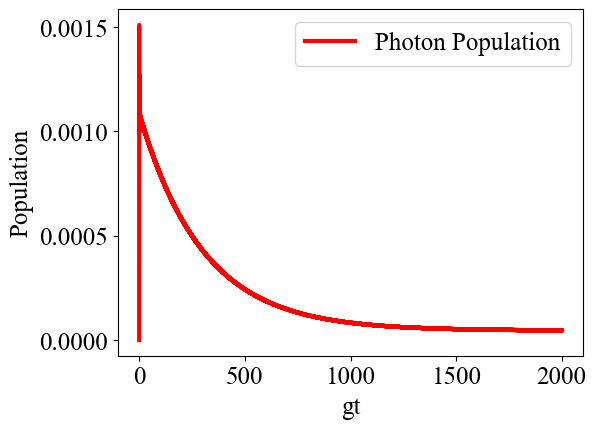

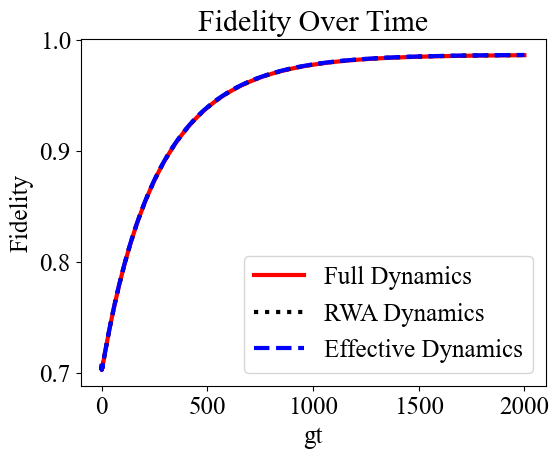

Running time: 44428.70 s


In [192]:
# the dynamics of fidelity
# Start timing
start_time = time.time()


#parameter
r = 3
g = 1
T = 2000
Nt = int(T * 700)
times = np.linspace(0, T, Nt)

gs = g * np.sinh(r)
gc = g * np.cosh(r)
kappa = 500 * g
omega0 = 10**5 * g
omegaa = omega0 + kappa * 10**3
C = 10**2
gamma = g**2 / kappa / C

Gamma2 = 4 * gc**2 / kappa
alpha = (2*Gamma2/3/gamma)**0.25
Omega = kappa / 50
delta = 2**0.5 * Omega / alpha

#calculate
fr = (1- np.tanh(2*r)**2)**0.5
omegap = 2 * (omega0 - omegaa * fr) / (1 - fr)
omegap2 = omegap / 2
omegab = (omegaa - omegap2) * fr
Delta_1 = omegap2 + omegab + omega0
Delta_2 = omegap2 + omegab - omega0
Delta_3 = omegap2 - omegab + omega0
Delta_4 = omegap2 - omegab - omega0


J_4 = - gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
Gamma_2 = 4 * gc**2 / kappa
Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)

# Calculate dynamics using the global parameter setup
F_full, N_aa = sr_dynamics_full()  # Full dynamics calculation
F_RWA = sr_dynamics_RWA()  # Effective dynamics calculation
F_eff = sr_dynamics_eff()  # Effective dynamics calculation


# Plotting results
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(times, N_aa, label='Photon Population', linewidth=3, linestyle='-', color='red')
plt.xlabel('gt')
plt.ylabel('Population')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(6, 4.5))
plt.plot(times, F_full, label='Full Dynamics', linewidth=3, linestyle='-', color='red')
plt.plot(times, F_RWA, label='RWA Dynamics', linewidth=3, linestyle=':', color='black')
plt.plot(times, F_eff, label='Effective Dynamics', linewidth=3, linestyle='--', color='blue')
plt.title('Fidelity Over Time')
plt.xlabel('gt')
plt.ylabel('Fidelity')
plt.legend(loc='best')
plt.show()

# save the data
np.savetxt('sr_F_t.txt', np.column_stack((times, F_full, F_RWA, F_eff)), delimiter=' ')

# End timing and print the execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")

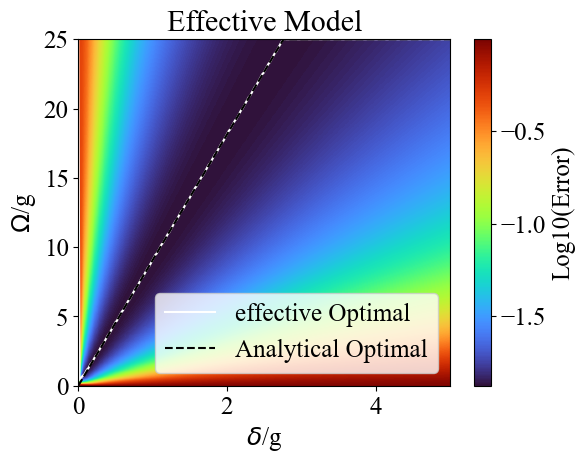

Running time: 29.78 s


In [136]:
# Start timing
start_time = time.time()

# Global variables and parameters
g = 1  # Coupling strength, unit 1
r = 3
gs = g * np.sinh(r)
gc = g * np.cosh(r)
kappa = 500 * g
omega_0 = 10**5 * g
omega_a = omega0 + kappa * 10**3
C = 10**2
gamma = g**2 / kappa / C
M = 300  # The number of data points for delta and Omega
ddelta = np.linspace(0, kappa/100, M)  # Range of delta values
dOmega = np.linspace(0, kappa/20, M)  # Range of Omega values

epsilon_eff = np.zeros((M, M))  # Array for effective master equation errors

# Perform calculations across a grid of delta and Omega values
for i in range(M):
    Omega = dOmega[i]
    for j in range(M):
        delta = ddelta[j]
        fr = (1- np.tanh(2*r)**2)**0.5
        omega_p = 2 * (omega_0 - omega_a * fr) / (1 - fr)
        omega_b = (omega_a - omega_p/2) * fr
        Delta_1 = omega_p/2 + omega_b + omega_0
        Delta_2 = omega_p/2 + omega_b - omega_0
        Delta_3 = omega_p/2 - omega_b + omega_0
        Delta_4 = omega_p/2 - omega_b - omega_0
        J_4 = - gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
        Gamma_2 = 4 * gc**2 / kappa
        Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)
        epsilon_eff[i, j] = 1 - sr_steadystate_eff()  # Effective master equation steady state fidelity

# Determine optimal Omega values from numerical results
Omega_eff = dOmega[np.argmin(epsilon_eff, axis=0)]

# Analytical solution for optimal alpha
alpha_ana = (8 * C * math.cosh(r)**2 / 3)**0.25  # Analytical solution for optimal alpha
Omega_ana = alpha_ana * ddelta / 2**0.5  # Analytical solution for optimal Omega
Omega_ana = np.clip(Omega_ana, None, dOmega[-1])  # Ensure values do not exceed the plot range


# Visualization of the results for Effective Model
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_eff), extent=[ddelta[0], ddelta[-1], dOmega[0], dOmega[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log10(Error)')
ax.plot(ddelta, Omega_eff, 'w-', label='effective Optimal')
ax.plot(ddelta, Omega_ana, 'k--', label='Analytical Optimal')
ax.legend(loc='lower right')
ax.set_xlabel('$\delta$/g')
ax.set_ylabel('$\Omega$/g')
plt.title('Effective Model')
plt.show()


# save data in .txt file
combined_array = np.zeros((M+1, M+2)) # combine all data as one array
combined_array[1:, 0] = Omega_ana
combined_array[1:, 1] = ddelta
combined_array[0, 2:] = dOmega
combined_array[1:, 2:] = epsilon_eff
file_path = 'sr_alpha_eff.txt' # the adress and name
np.savetxt(file_path, combined_array, delimiter=' ') # write the data in the file

# Print the running time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")



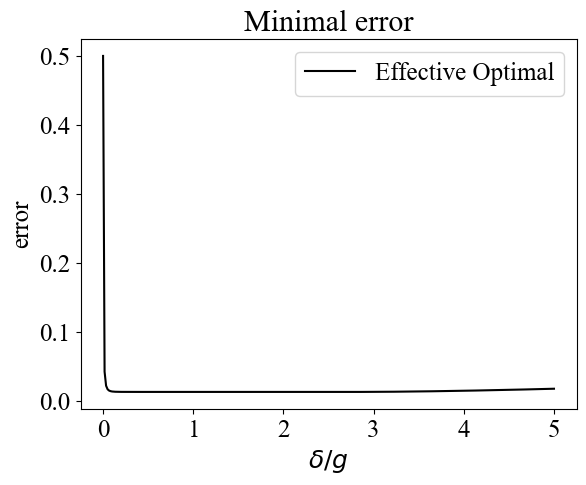

In [138]:

error_eff = np.min(epsilon_eff, axis=0)
plt.plot(ddelta, error_eff, 'k-', label='Effective Optimal')
plt.xlabel('$\delta/g$')
plt.ylabel('error') 
plt.legend(loc='upper right')
plt.title('Minimal error')
plt.show()

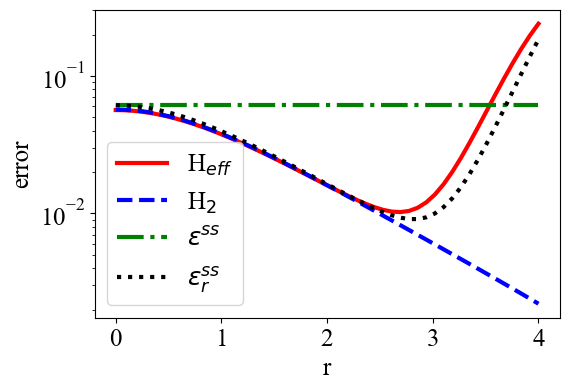

runing time：0.43 s


In [64]:
#This unit is for the scaling of cooperativity $C$

# Start timing
start_time = time.time()


# Global variables and parameters
g = 1  # Coupling strength, unit 1
kappa = 500 * g # make sure kappa>>g\cosh(r)
omega_0 = 10**5 * g
omega_a = omega0 + kappa * 10**3
C = 10**2
gamma = g**2 / kappa / C 
M = 50 # data point
dr = np.linspace(0.001, 4, M) # log10(C)
Omega = kappa / 30 # fixed Omega
epsilon_eff = np.zeros(M) # array for saving data
epsilon_H2 = np.zeros(M) # array for saving data
epsilon_ana = np.zeros(M) # array for saving data
epsilon = np.zeros(M) + (3/8/C)**0.5

# calculate
for j in range (M): 
    r = dr[j] # pick each cooperativity
    gs = g * np.sinh(r)
    gc = g * np.cosh(r)
    fr = (1- np.tanh(2*r)**2)**0.5
    omega_p = 2 * (omega_0 - omega_a * fr) / (1 - fr)
    omega_b = (omega_a - omega_p/2) * fr
    Delta_1 = omega_p/2 + omega_b + omega_0
    Delta_2 = omega_p/2 + omega_b - omega_0
    Delta_3 = omega_p/2 - omega_b + omega_0
    Delta_4 = omega_p/2 - omega_b - omega_0
    J_4 = - gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
    Gamma_2 = 4 * gc**2 / kappa
    Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)
    alpha = (2 * Gamma_2 / 3 / gamma)**0.25
    delta = 2**0.5 * Omega / alpha
#    alpha = (8 * C * math.cosh(r)**2 / 3)**0.25
 #   delta = 2**0.5 * Omega / alpha
    epsilon_eff[j] = 1 - sr_steadystate_eff() # solution from effective master equation
    epsilon_H2[j] = 1 - sr_steadystate_H2() # solution from full master equation
    epsilon_ana[j] = math.sqrt(3 * gamma / 2 / Gamma_2) + 3 * Gamma_4 / 2 / Gamma_2# analytical solution


# plot figure
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4))  # figure size

plt.plot(dr, epsilon_eff, label='H$_{eff}$', linewidth=3, linestyle='-', color='r')  
plt.plot(dr, epsilon_H2, label='H$_2$', linewidth=3, linestyle='--', color='b')
plt.plot(dr, epsilon, label='$\epsilon$$^{ss}$', linewidth=3, linestyle='-.', color='g')
plt.plot(dr, epsilon_ana, label='$\epsilon$$_r^{ss}$', linewidth=3, linestyle=':', color='k')# show the log of axis
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('error')
plt.tick_params(axis='both', which='major')
plt.legend(loc='lower left')
# Save the plot as a PDF file before showing it
plt.savefig('sr_error_r.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


# save the data in .txt file
np.savetxt('sr_error_r.txt', np.column_stack((dr, epsilon, epsilon_eff, epsilon_H2, epsilon_ana)), delimiter=' ')

# end timing
end_time = time.time()
# print the time
execution_time = end_time - start_time
print(f"runing time：{execution_time:.2f} s")


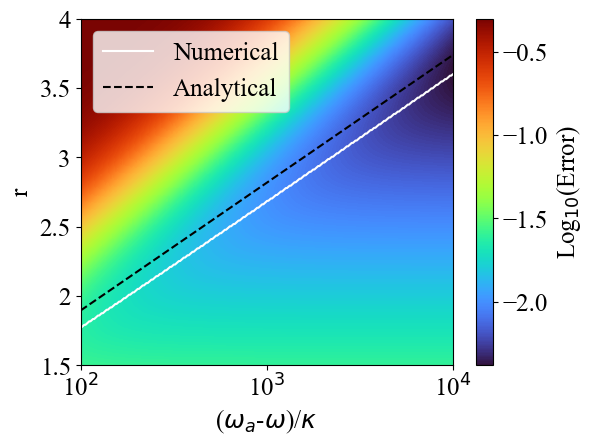

Running time: 34.58 s


In [7]:
# error versus r and (omega_a - omega_0) / kappa

# Start timing
start_time = time.time()

g = 1
kappa = 500 * g
Omega = kappa / 40
C = 10**2
gamma = g**2 / kappa / C
omega_0 = 10**5 * g

M = 300
epsilon_eff = np.zeros((M, M))
dr = np.linspace(1.5, 4, M)

log_domega_a = np.linspace(2, 4, M) 
_domega_a = np.power(10, log_domega_a) # = (omega_a - omega_0)/kappa


for i in range (M):
    r = dr[i]
    gs = g * np.sinh(r)
    gc = g * np.cosh(r)
    fr = (1- np.tanh(2*r)**2)**0.5
    for j in range (M):
        omega_a = _domega_a[j] * kappa + omega_0
        omega_p = 2 * (omega_0 - omega_a * fr) / (1 - fr)
        omega_b = (omega_a - omega_p/2) * fr
        Delta_1 = omega_p/2 + omega_b + omega_0
        Delta_2 = omega_p/2 + omega_b - omega_0
        Delta_3 = omega_p/2 - omega_b + omega_0
        Delta_4 = omega_p/2 - omega_b - omega_0
        J_4 = - gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
        Gamma_2 = 4 * gc**2 / kappa
        Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)
        alpha = (2 * Gamma_2 / 3 / gamma)**0.25
        delta = 2**0.5 * Omega / alpha
        epsilon_eff[i][j] = 1 - sr_steadystate_eff()
        
        
# Analytical solution
r_ana = 0.2 * np.log((6*C)**-0.5 * 32 * _domega_a**2)

# Numerical solution
r_num = dr[np.argmin(epsilon_eff, axis=0)]




# Second plot (Effective Model)
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_eff), extent=[log_domega_a[0], log_domega_a[-1], dr[0], dr[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log$_{10}$(Error)')
ax.plot(log_domega_a, r_num, 'w-', label='Numerical')
ax.plot(log_domega_a, r_ana, 'k--', label='Analytical')
ax.legend(loc='upper left')
ax.set_xlabel('($\omega$$_a$-$\omega$)/$\kappa$')
ax.set_ylabel('r')
x_ticks = [2, 3, 4]
x_ticks_label = ['10$^2$', '10$^3$', '10$^4$']
y_ticks = [1.5, 2, 2.5, 3, 3.5, 4]
y_ticks_label = y_ticks
plt.xticks(x_ticks, x_ticks_label, fontsize=18)#, fontdict={'family': 'Times New Roman'})
plt.yticks(y_ticks, y_ticks_label, fontsize=18)#, fontdict={'family': 'Times New Roman'})

# Add text in the top-left corner of the plot
#fig.text(-0.01, 0.9, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left')

# Save the plot as a PDF file before showing it
plt.savefig('sr_error_r_omega.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Now display the plot
plt.show()

# save data in .txt file
combined_array = np.zeros((M+1, M+2)) # combine all data as one array
combined_array[1:, 0] = r_ana
combined_array[1:, 1] = _domega_a
combined_array[0, 2:] = dr
combined_array[1:, 2:] = epsilon_eff
file_path = 'sr_error_r_omega.txt' # the adress and name
np.savetxt(file_path, combined_array, delimiter=' ') # write the data in the file


# Print the running time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")



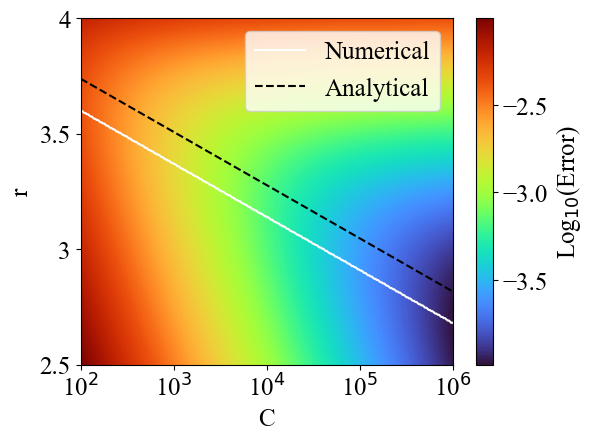

Running time: 33.76 s


In [58]:
# error versus r and C

# Start timing
start_time = time.time()

g = 1
kappa = 500 * g
omega_0 = 10**5 * g
omega_a = omega_0 + kappa * 10**4

M = 300
epsilon_eff = np.zeros((M, M))
dr = np.linspace(2.5, 4, M)
log_dC = np.linspace(2, 6, M)
dC = np.power(10, log_dC)
Omega = kappa / 40

for i in range (M):
    r = dr[i]
    gs = g * np.sinh(r)
    gc = g * np.cosh(r)
    fr = (1- np.tanh(2*r)**2)**0.5
    for j in range (M):
        C = dC[j]
        gamma = g**2 / kappa / C
        omega_p = 2 * (omega_0 - omega_a * fr) / (1 - fr)
        omega_b = (omega_a - omega_p/2) * fr
        Delta_1 = omega_p/2 + omega_b + omega_0
        Delta_2 = omega_p/2 + omega_b - omega_0
        Delta_3 = omega_p/2 - omega_b + omega_0
        Delta_4 = omega_p/2 - omega_b - omega_0
        J_4 = - gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
        Gamma_2 = 4 * gc**2 / kappa
        Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)
        alpha = (2 * Gamma_2 / 3 / gamma)**0.25
        delta = 2**0.5 * Omega / alpha
        epsilon_eff[i][j] = 1 - sr_steadystate_eff()
        
        
# Analytical solution
r_ana = 0.2 * np.log((6*dC)**-0.5 * 32 * (omega_a - omega_0)**2 / kappa**2)

# Numerical solution
r_num = dr[np.argmin(epsilon_eff, axis=0)]




# Second plot (Effective Model)
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_eff), extent=[log_dC[0], log_dC[-1], dr[0], dr[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log$_{10}$(Error)')
ax.plot(log_dC, r_num, 'w-', label='Numerical')
ax.plot(log_dC, r_ana, 'k--', label='Analytical')
ax.legend(loc='upper right')
ax.set_xlabel('C')
ax.set_ylabel('r')
x_ticks = [2, 3, 4, 5, 6]
x_ticks_label = ['10$^2$', '10$^3$', '10$^4$', '10$^5$', '10$^6$']
y_ticks = [2.5, 3, 3.5, 4]
y_ticks_label = y_ticks
plt.xticks(x_ticks, x_ticks_label, fontsize=18)#, fontdict={'family': 'Times New Roman'})
plt.yticks(y_ticks, y_ticks_label, fontsize=18)#, fontdict={'family': 'Times New Roman'})

# Add text in the top-left corner of the plot
#fig.text(-0.01, 0.9, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left')

# Save the second plot as a PDF file before showing it
plt.savefig('sr_error_r_C.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Now display the plot
plt.show()

# save data in .txt file
combined_array = np.zeros((M+1, M+2)) # combine all data as one array
combined_array[1:, 0] = r_ana
combined_array[1:, 1] = dC
combined_array[0, 2:] = dr
combined_array[1:, 2:] = epsilon_eff
file_path = 'sr_error_r_C.txt' # the adress and name
np.savetxt(file_path, combined_array, delimiter=' ') # write the data in the file

# Print the running time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")

